# Fitting Data

_This notebook is heavily based on the iminuit [documentation](https://iminuit.readthedocs.io/en/stable/notebooks/basic.html)._

<hr style="border:2px solid gray">

## Index: <a id='index'></a>

1. [Interpolation](#interpolation)
1. [Introduction to iminuit](#iminuit)
1. [A Quick iminuit Example](#iminuit_ex)
1. [The Minuit Object](#minuit_obj)
1. [Parameters of a Minuit Object](#minuit_obj)

    1. [The Basics](#tb)
    1. [Gradient Descent](#gd)
    1. [The Minuit object](#tmo)
    1. [Parameter Uncertainties, Covariances, and Confidence Intervals](#pucaci)
    1. [Maximum-likelihood fits](#mlf)

<hr style="border:2px solid gray">

# Interpolation [^](#index) <a id='interpolation'></a>


### Linear Interpolation 

The simplest way to draw a line of best fit between data is to use linear inerpolation. In linear interpolation, we connect successive data points with **straight lines** and use this to estimate the values between the points. scipy has a built in linear interpretor.

Below is an example using linear interpolation. The first plot visualises this intepretation, and the second plot shows the distribution of errors (the discrepancies between the interpolated and the true values).

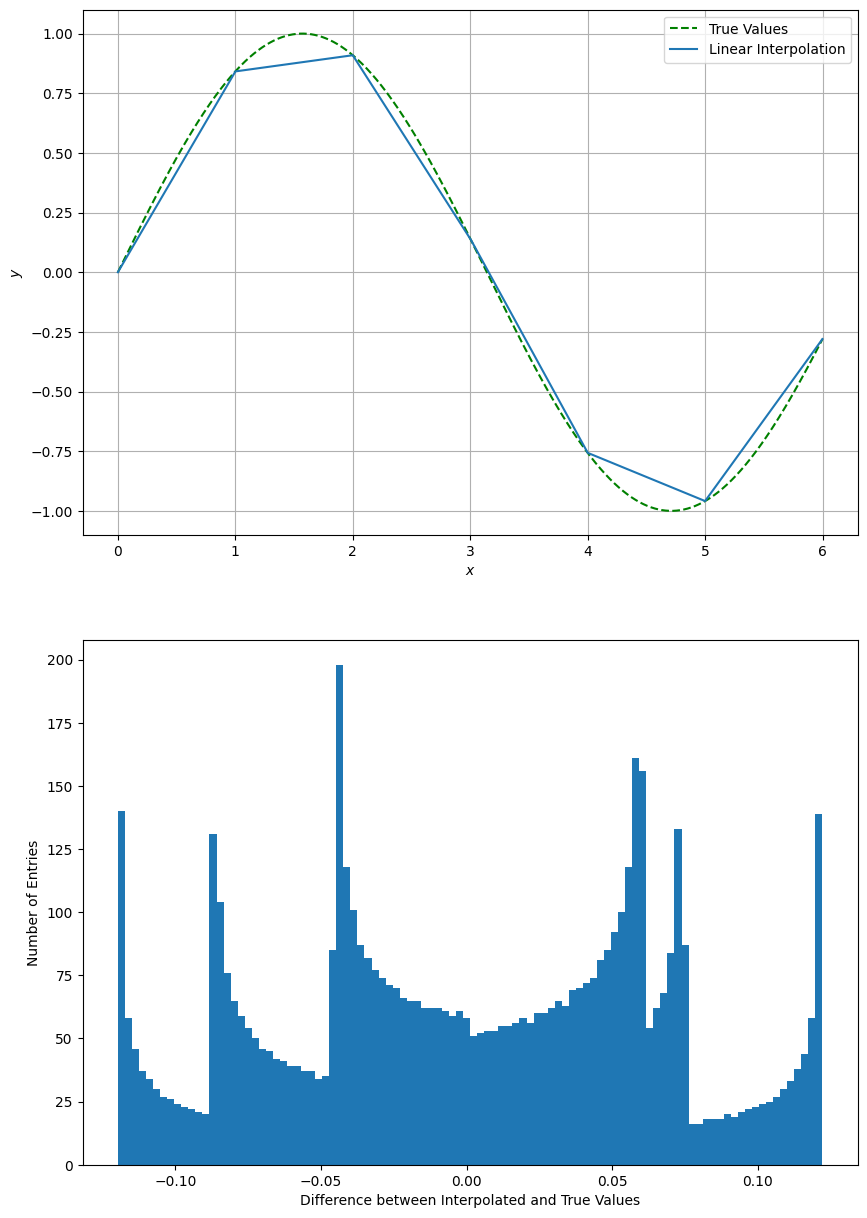

In [80]:
import numpy as np
import scipy as sp
import pylab as pl
import scipy.interpolate as spi

pl.rcParams['figure.figsize'] = [10, 15] 


x=np.linspace(0,6, 7) 
y=np.sin(x)

# now get the finer binned version for comparison
xf=np.arange(0,6,0.001) 
yf=np.sin(xf)

pl.subplot(2,1,1)
pl.plot(xf,yf,"g--",label="True Values")
pl.xlabel("$x$")
pl.ylabel("$y$")

# Here we call the linear 1D interpolator
f=spi.interp1d(x, y)

# f is a function that will return the predicted value of y for any x
pl.plot(xf,f(xf), label="Linear Interpolation")
pl.grid()
pl.legend(loc="upper right")

#We can use a histogram to display the differences between the interpolated and true values
ydiff=yf-f(xf)
pl.subplot(2,1,2)
pl.hist(ydiff,bins=100)
pl.xlabel("Difference between Interpolated and True Values")
pl.ylabel("Number of Entries")

pl.show()

As we can see from the plot above, the differences can be quite large. We can also notice that the histogram has some underlying structure - this indicates that we have introduced a systematic effect. 

### Cubic Spline 

An alternative interpolation method is to use a **spline**. A cubic spline is the most commonly used as it provides both smoothness and double differentiability.

We can now evaluate the performance of the cubic spline interpolator by having it act on the same data as we used with the linear interpolator. To achieve this, we use the same `spi.interp1d` function, but specify the keyword argument `kind='cubic'`

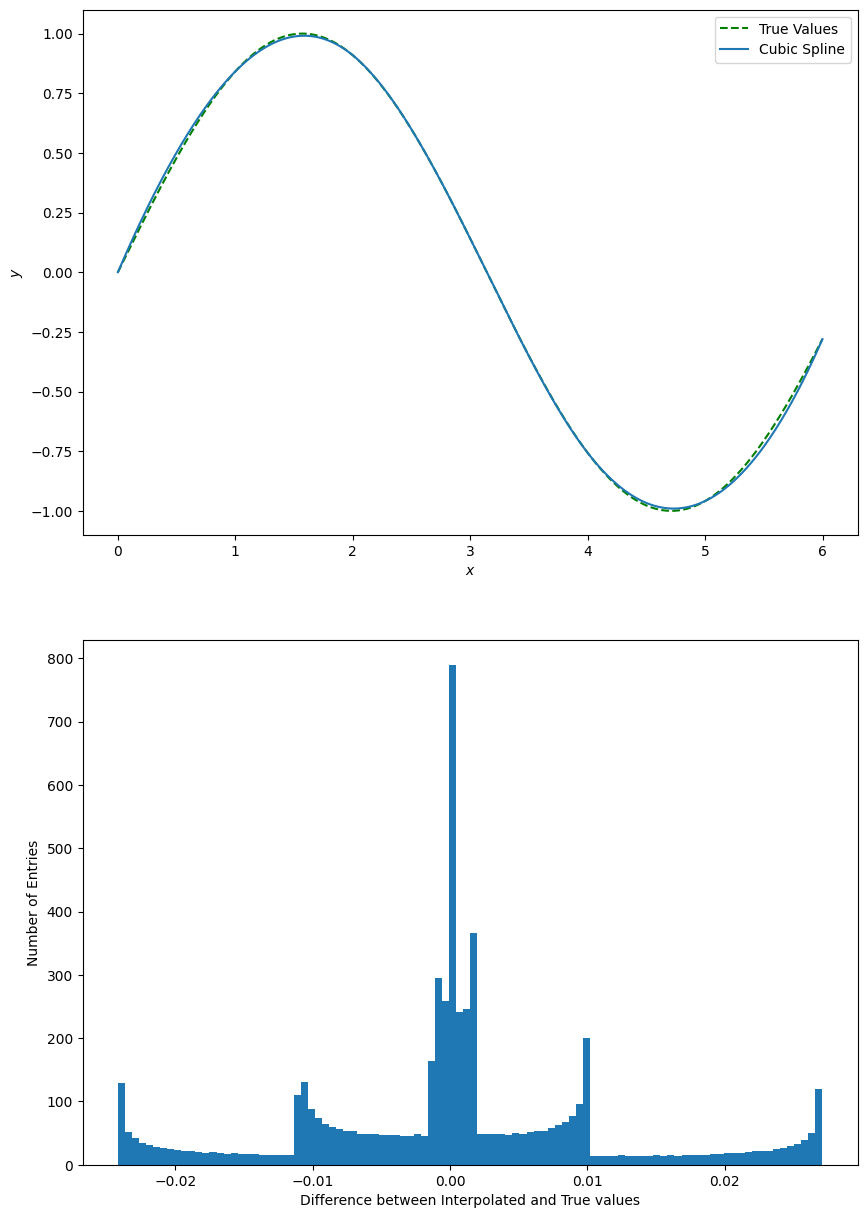

In [81]:
pl.subplot(2,1,1)
pl.plot(xf,yf,"g--",label="True Values")
pl.xlabel("$x$")
pl.ylabel("$y$")

f=spi.interp1d(x, y, kind='cubic')

pl.plot(xf,f(xf), label="Cubic Spline")
pl.legend(loc="upper right")

# Visualise the differences on a histogram

ydiff=yf-f(xf)
pl.subplot(2,1,2)
pl.hist(ydiff,bins=100)
pl.xlabel("Difference between Interpolated and True values")
pl.ylabel("Number of Entries")

pl.show()

Using a cubic spline as an approximation provides a much better fit, with significantly smaller differences between the interpolated and true values *(notice that the x-axis scale is much smaller than in the linear example)*. 

Even with this improved accuracy, there is still a structure present in our error distribution which indicates the presence of systematic biases (although these biases are small when the differences are small).

SciPy also implements two-dimensional forms of these interpolation algorithms.

It's important to note that while using a cubic spline is generally effective, it is not a foolproof solution. In cases where there aren't enough data points, the cubic spline can occasionally overestimate or underestimate the true curve (as shown in the example below). 

In [82]:
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = spi.interp1d(x, y)
f2 = spi.interp1d(x, y, kind='cubic')

xnew = np.linspace(0, 10, num=101, endpoint=True)
yt=np.cos(-xnew**2/9.0)

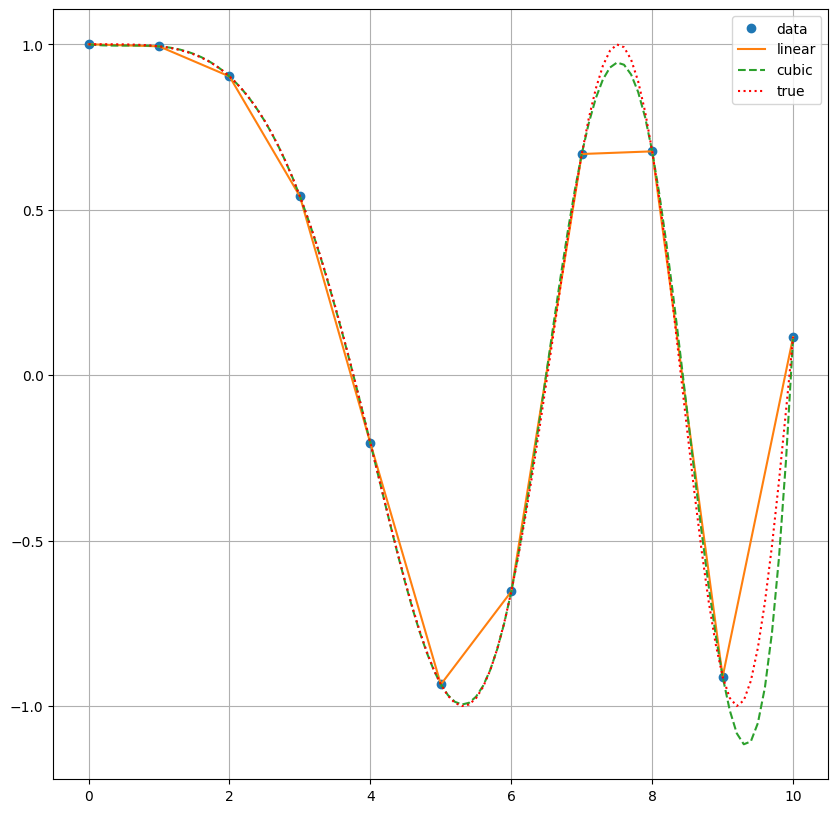

In [83]:
pl.rcParams['figure.figsize'] = [10, 10] 
pl.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--',xnew,yt,'r:')
pl.legend(['data', 'linear', 'cubic','true'], loc='best')
pl.grid()
pl.show()

<div style="background-color:#C2F5DD">

### Exercise 

Select a function where different regions have different scales (such as $y=\cos(x^2)$ with $0 \le x \lt 10$ for example) and investigate how well a cubic spline is able to interpolate with different sampling separations.
    
This should help you understand how interpolations work and their limitations.

<hr style="border:2px solid gray">

# Introduction to iminuit [^](#index) <a id='iminuit'></a>

_In this section, we will introduce the basics of iminuit. Be aware that at the end of this notebook is a **long** exercise designed to give you more practice fitting a curve from the ground up._

One of the most important elements in data analysis is fitting the data distributions. 

When performing a fit, we generally want to **minimise** how far the fitted solution deviates from the data. To obtain the fitted solution, we must make some assumptions about our dataset. For example, we might assume that the data points are distributed according to a well defined probability density function (PDF), or that the data points will follow some function. 

Scipy has a series of functions for fitting data using scipy.optimize, which work well for simple problems. In this notebook we will instead use the more advanced [minuit](https://root.cern.ch/download/minuit.pdf) developed by CERN. This is written in C++ and wrapped in python as [iminuit](https://iminuit.readthedocs.io/en/stable/). iminuit is the successor of pyminuit.

iminuit is an integrated software that combines a local minimizer (called Migrad, which uses the method of gradient descent and Newton's method) and two error calculators (called Hesse and the Minos). 

You provide imininuit with an analytical function (the function you wish to fit), which accepts one or several parameters, and an initial guess of the parameter values. It will then find a local minimum of this function starting from the initial guess. This minimiser is called **Migrad**, and it uses gradient descent and Newton's method.

iminuit also has the ability to compute uncertainty estimates for model parameters. There are two possible error calculators which can be used to compute the uncertainty estimates, **Hesse** and **Minos**, with each having different pros and cons.


For a more detailed understanding of iminuit, there are some excellent [tutorials](https://iminuit.readthedocs.io/en/stable/tutorials.html) on the iminuit website.

<div style="background-color: #FFFACD">

### Gradient Descent

_This is repeated content from the stat course, to offer a quick reminder if required._
    
For functions with more than one variable, we can use a gradient descent algorithm to find minima and maxima. These methods only rely on the first derivative (the gradient) to find the best direction to step in to find the minimum (or maximum). They don't use the second derivative because for a large number of parameters $n$, the number of terms in the second derivative grows as $n^{2}$ so this can get quite costly. 

There are  a number of subtle different algorithms which rely on gradient descent but we'll go over a simple example. The  way this works is as follows. 

First, we initialise the algorithm at some set of values for the parameters $\boldsymbol{\theta}_{init}$. Then we calcualte the gradient of the negative log-likelihood - $\nabla(q)\rvert_{\boldsymbol{\theta}_{init}}$ - at that initial point. The gradient defines a direction in which the negative log-likelihood changes most rapidly - this makes this direction a good direction to search for a smaller value of $q$.

$$
\begin{align}
\nabla(q)\rvert_{\boldsymbol{\theta}_{init}} &=   
        \begin{bmatrix}
           \frac{\partial q}{\partial \theta_{1}} \\
           \frac{\partial q}{\partial \theta_{2}} \\
           \vdots \\
           \frac{\partial q}{\partial \theta_{n}}
        \end{bmatrix}_{\boldsymbol{\theta}=\boldsymbol{\theta}_{init}}
\end{align}   
$$

Since we want to *decrease* $q$, we need to move against this gradient. We step along the negative gradient direction until we find a new minimum - i.e we pick a step sise $h$ and keep adding it to the initial point until the value of $q$ stops decreasing, 


$$
\boldsymbol{\theta}_{k} = k\times h - \nabla(q)\rvert_{\boldsymbol{\theta}_{init}} 
$$




In [84]:
# basic setup of the notebook
from matplotlib import pyplot as plt
import numpy as np

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

<hr style="border:2px solid gray">

# A Quick iminuit Example [^](#index) <a id='iminuit_ex'></a>

In this first section, we look at a simple case where a straight line should be fitted to a scattered (x,y) dataset. A line has two parameters, which we call _m_ and _c_. We go through the full fit, showing all basic steps to get you started quickly. In subsequent sections we will revisit the steps in more detail.

First, we should create our data we would like to fit.

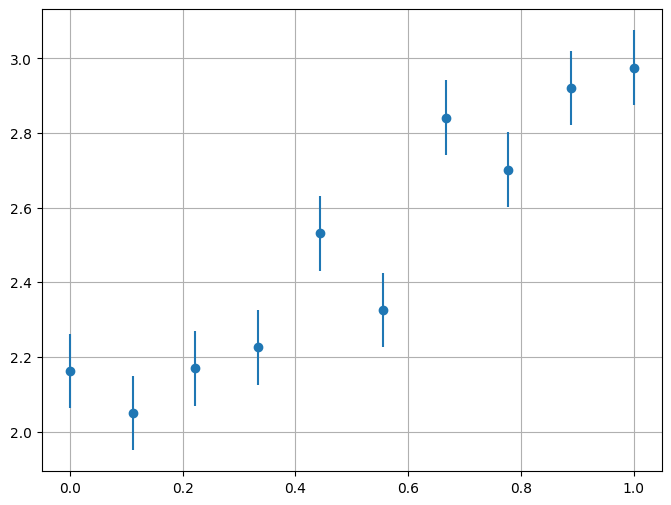

In [40]:
def line(x, m, c):
    return  c + m * x

# generate random toy data with random offsets in y
np.random.seed(1)
data_x = np.linspace(0, 1, 10)
data_yerr = 0.1  # could also be an array
data_y = line(data_x, 1, 2) + data_yerr * np.random.randn(len(data_x))

# draw toy data
plt.rcParams['figure.figsize'] = [8, 6] 
plt.errorbar(data_x, data_y, data_yerr, fmt="o")
plt.grid()
plt.show()

To recover the parameters m and c of the line model from this data, we need to a minimize a suitable cost function. The cost function must be twice differentiable and have a minimum at the optimal parameters. Here we will use the **method of least-squares**, where we aim to minimise the sum of squared residuals.

We can display the Minuit object _m_ to get various pieces of information about our fit. For now, ignore the colours in the table outputs.

<div style="background-color:#C2F5DD">

### Test your Understanding

Why must the cost function be twice differentiable?

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (χ²/ndof = 1.8)      │              Nfcn = 42               │
│ EDM = 2.26e-23 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   0.97    │   0.10    │            │            │         │         │       │
│ 1 │ c    │   2.01    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       m       c │
├───┼─────────────────┤
│ m │ 0.00982 -0.0049 │
│ c │ -0.0049 0.00345 │
└───┴─────────────────┘

<ValueView m=0.9660364327568123 c=2.0072676945408348>
<ErrorView m=0.09908673136779061 c=0.058775376160377>

0.9660364327568123
0.09908673136779061


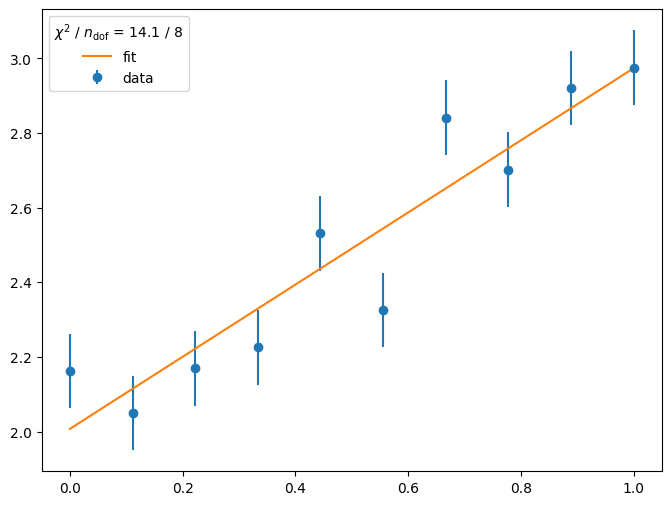

In [87]:
# iminuit contains a LeastSquares class to conveniently generate a least-squares cost function.
# We will revisit how to write this by hand in a later section.

least_squares = LeastSquares(data_x, data_y, data_yerr, line)

m = Minuit(least_squares, m=0, c=0)  # starting values for m and c.

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

#print the values and errors and then note how to access individual ones.

display(m)

print(m.values)
print(m.errors)
print()

print(m.values[0])
print(m.errors[0])


# try printing out the parameters, values and errors to see the format

for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
    
# Display legend with some fit info
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(data_x) - m.nfit}",
]       
# Draw data and the fitted line

plt.rcParams['figure.figsize'] = [8, 6] 

plt.errorbar(data_x, data_y, data_yerr, fmt="o", label="data")
plt.plot(data_x, line(data_x, *m.values), label="fit")    

plt.legend(title="\n".join(fit_info))

plt.show()

In the following sections, we will detail how this process works step by step: how the Minuit object is initialized, how to run the algorithms, and how to get the results.

<hr style="border:2px solid gray">

# The Minuit Object [^](#index) <a id='minuit_obj'></a>

### Initialising the Minuit Object

To minimise a function, we must first create an instance of the Minuit class. We then pass the loss function (which also specifies the analytic function) and the starting parameter values to said class. This setup does not start the minimisation.

### Initial parameter values

It is important to set appropriate starting values. If a function has several minima, the minimum found will depend on the starting point. Even if it has only one minimum, starting in the proximity of the minimum will cause iminuit to converge faster.

We can set the starting point using the parameter names as keywords, name = value (this is used in the example below), or we can just pass starting values as positional arguments: `Minuit(least_squares, 5, 5)`

In [42]:
# create an instance of the Minuit class
m = Minuit(least_squares, m=0, c=0)
display (m)

┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │    0.0    │    0.1    │            │            │         │         │       │
│ 1 │ c    │    0.0    │    0.1    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


If we forget a parameter or mistype, Minuit will raise an error. Two examples of this are given below.

In [43]:
m=Minuit(least_squares)

RuntimeError: starting value(s) are required for [m c]

In [44]:
m=Minuit(least_squares,a=0,b=0)

RuntimeError: a is not one of the parameters [m c]

### Using iminuit with Data Structures

We can also use iminuit with functions that accept data structures such as numpy arrays. This has pros and cons.

**Pros**

* Easy to change number of fitted parameters
* Sometimes simpler function body that’s easier to read
* Technically this is more efficient, but this is hardly going to be noticable

**Cons**

* iminuit cannot figure out names for each parameter

To demonstrate, we will use a version of the line model which accepts the parameters as a numpy array.

In [45]:
def line_np(x, par):
    return np.polyval(par, x)  # for len(par) == 2, this is a line

Calling line_np with more or fewer arguments is easy. For $n$ arguments, a polynomial of order $n$ is used to predict the behavior of the data.

The built-in cost functions support such a model. For it to be detected properly, we need to pass the starting values in the form of a single sequence of numbers.

In [57]:
least_squares_np = LeastSquares(data_x, data_y, data_yerr, line_np)

display(Minuit(least_squares_np, (5, 5)))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,


We have used a tuple here for initialisation, but any sequence (including lists and numpy arrays) would work. iminuit uses the length of the sequence to detect how many parameters the model has. By default, the parameters are named automatically $x_0$ to $x_N$. 

We can override this naming convention with the keyword argument `name`, passing a sequence of parameter names. Of course, this sequence must be of the same length as the sequence of starting points.

In [58]:
display (Minuit(least_squares_np, (5, 5), name=("a", "b")))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,5.00,0.05,,,,,
1,b,5.00,0.05,,,,,


Since least_squares_np works for parameter arrays of any length, we can easily change the number of fitted parameters. For example, we have set up the Minuit object to fit a fourth order polynomial.

In [56]:
display (Minuit(least_squares_np, (5, 5, 5, 5)))

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,5.00,0.05,,,,,
1,x1,5.00,0.05,,,,,
2,x2,5.00,0.05,,,,,
3,x3,5.00,0.05,,,,,


It is often useful to try different orders of a polynomial model. If the order is too small, the polynomial will not follow the data (an underfit). If it is too large, the model pick up random fluctuations rather than the underlying trend (an overfit). 

We can figure out the right order by experimenting or using an algorithm like cross-validation (this will be discussed in greater detail in the machine learning notebooks).

<div style="background-color:#C2F5DD">

### Exercise

Fit the following data set with different orders of polynomials. As you increase the order of the polynomial how does the goodness of fit change? When does the fit show signs of overfitting? 

In [52]:
x = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

y_measured = [343.39452514, 251.31914561, 186.7806368, 121.30027965, 45.23336652, 23.49470302, 18.46581766, 6.58329486, 1.98522328, -
              6.74799454, -7.55489379, -29.55544088, -31.32898172, -36.27525348, -25.23860169, -1.09156819, 52.32898397, 225.38126087, 460.67437131]

y_err = [141.312,  86.205,  49.632,  26.877,  13.872,   7.197,   4.08 ,
         2.397,   0.672,   1.923,   5.568,   9.795,  13.488,  14.883,
        11.568,   0.483,  22.08 ,  60.477, 119.712]


<hr style="border:2px solid gray">

# Parameters of a Minuit Object [^](#index) <a id='minuit_param'></a>

### Inspecting Current Parameters

We can check the current parameter values and settings with the method `Minuit.params` at any time, which we can display nicely with the display function (or we could just see the output). The table will be updated once you run the actual minimisation. To look at the initial conditions later, use Minuit.init_params. 

In [59]:
display (m.params)
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,m,0.0,0.1,,,,,
1,c,0.0,0.1,,,,,


,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,m,0.0,0.1,,,,,
1,c,0.0,0.1,,,,,


Minuit.params returns a tuple-like container of Param objects, which are data objects with attributes that we can query. Use `repr()` to get a detailed representation of the data object.

In [60]:
for p in m.params:
    print(repr(p), "\n")

Param(number=0, name='m', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None) 

Param(number=1, name='c', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None) 



### Parameters with Limits
iminuit allows you to set parameter limits. Often a parameter is limited mathematically or physically to a certain range. For example, if your function contains sqrt(x), then x must be non-negative. We can set upper, lower, or two-sided limits for each parameter individually with the limits property:

* Lower limit: use Minuit.limits = (**your min_value**, None) or (**your min_value**, float("infinity"))
* Upper limit: use Minuit.limits = (None, **your max_value**) or (-float("infinity"), **your max_value**)
* Two-sided limit: use Minuit.limits = (**your min_value**, **your max_value**)
* Remove limits: use Minuit.limits = None or (-float("infinity"), float("infinity")

We can also set limits for several parameters at once with a sequence. To impose the limits m≥0 and 0≤c≤10 in our example, we use:

In [61]:
m.limits = [(0, None), (0, 10)]
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,m,0.0,0.1,,,0,,
1,c,0.0,0.1,,,0,10,


### Fixing and Releasing Parameters

In some cases, we may have a parameter that needs to be temporarily set to a **fixed value**. For example, we may wish to observe how other parameters adapt when this value is made constant.

Another use case is if we had a complex function with numerous parameters, each with varying impacts on the function. We could then assist the minimiser in finding the minimum by initially fixing the less influential parameters to their initial guesses and only fitting the significant parameters. 

Once the minimum is obtained under these conditions, we could then release the fixed parameters and optimise all the parameters together - this speeds up the fitting since Minuit retains the previous minimisation state and resumes from there. The time required for minimisation approximately scales with the square of the number of parameters. Thus by performing iterated minimisation over parameter subspaces, this time can be reduced.

To fix an individual parameter, you can utilise the keyword `Minuit.fixed[name] = True`. Alternatively, we could use the parameter index instead of the name. In our example, we first fix the parameter "m". We then call `migrad` to fit the data, before releasing m and fixing c.

In [70]:
m.fixed["m"] = True
m.params

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,m,0.48,0.05,,,0,,yes
1,c,2.251,0.032,,,0,10,


In [71]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.31 (χ²/ndof = 4.3)      │              Nfcn = 153              │
│ EDM = 3.07e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   0.48    │   0.05    │            │            │    0    │         │  yes  │
│ 1 │ c    │   2.251   │   0.032   │            │            │    0    │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────┐
│   │     m     c │
├───┼─────────────┤
│ m │     0  0e-3 │
│ c │  0e-3 0.001 │
└───┴─────────────┘

In [72]:
m.fixed[1] = False
m.fixed[0] = True
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 38.31 (χ²/ndof = 4.3)      │              Nfcn = 159              │
│ EDM = 3.07e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   0.48    │   0.05    │            │            │    0    │         │  yes  │
│ 1 │ c    │   2.251   │   0.032   │            │            │    0    │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────┐
│   │     m     c │
├───┼─────────────┤
│ m │     0  0e-3 │
│ c │  0e-3 0.001 │
└───┴─────────────┘

### Varying the Parameter Starting Points 

It is sometimes useful to manually change the values of some fixed parameters and fit the others, or to restart the fit from another starting point. 

For example, if the cost function has several minima, changing the starting value can be used to find the other minimum. We show an example below for a function which has 2 minima. You may ignore the line which calls errordef, although an explanation is provided below the code cells if you are interested.

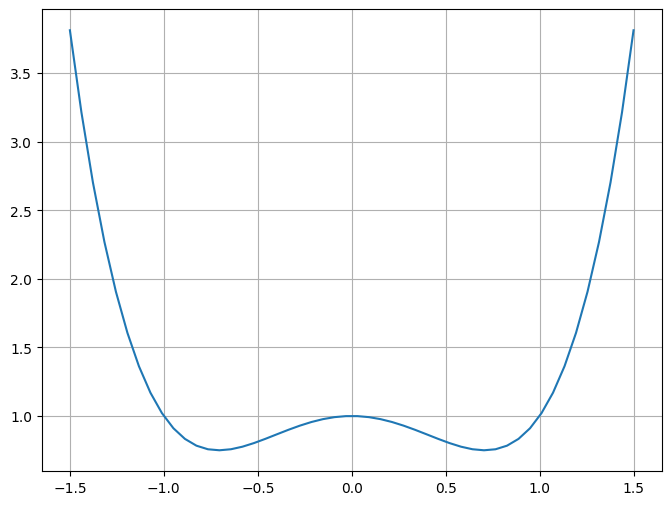

In [74]:
def cost_function_with_two_minima(x):
    return x ** 4 - x ** 2 + 1

cost_function_with_two_minima.errordef = Minuit.LEAST_SQUARES

x = np.linspace(-1.5, 1.5)
plt.plot(x, cost_function_with_two_minima(x))
plt.grid()
plt.show()

In [88]:
# Starting at -0.1 gives the left minimum
m = Minuit(cost_function_with_two_minima, x=-0.1)
m.migrad()
print("Starting value -0.1, minimum at", m.values["x"])

# Changing the starting value to 0.1 gives the right minimum
m.values["x"] = 0.1  # m.values[0] = 0.1 also works
m.migrad()
print("Starting value +0.1, minimum at", m.values["x"])

Starting value -0.1, minimum at -0.7085906080341975
Starting value +0.1, minimum at 0.708796091342642


<div style="background-color: #FFF8C6">

### Changing the Uncertainty Bounds

Let us make a custom least-squares function and try to run Migrad on it, and then display the Minuit object. 

In [92]:
def custom_least_squares(a, b):
    ym = line(data_x, a, b)
    z = (data_y - ym) / data_yerr
    return np.sum(z ** 2)

Minuit(custom_least_squares, a=5, b=5).migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06                      │              Nfcn = 34               │
│ EDM = 4.11e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.97    │   0.10    │            │            │         │         │       │
│ 1 │ b    │   2.01    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00982 -0.0049 │
│ b │ -0.0049 0.00345 │
└───┴─────────────────┘

<div style="background-color: #FFF8C6">

In statistical problems, there are two kinds of cost functions to minimise: the negative log-likelihood and the least-squares function. If you define your own cost function as we have done here, you must also make sure you are using the appropriate cost function.

The `errordef` parameter is used to compute the correct uncertainties. 

Each has a corresponding value for errordef:
- 0.5 or the constant: `Minuit.LIKELIHOOD` for negative log-likelihood functions
- 1 or the constant: `Minuit.LEAST_SQUARES` for least-squares functions

The origin of these numbers is not too complicated, but cannot be explained briefly. If you are curious, have a look into  [“Error computation with HESSE and MINOS”](https://iminuit.readthedocs.io/en/stable/notebooks/hesse_and_minos.html), which explains in depth how uncertainties are computed and where this value comes from.

For our custom cost function, we need to set m.errordef=1 or equivalent and more readable m.errordef=Minuit.LEAST_SQUARES, because it is of the least-squares type. If we do that, the warning disappears.



In [98]:
m = Minuit(custom_least_squares, a=5, b=5)
m.errordef = 1
m.migrad()  # no warning

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06                      │              Nfcn = 34               │
│ EDM = 4.11e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.97    │   0.10    │            │            │         │         │       │
│ 1 │ b    │   2.01    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00982 -0.0049 │
│ b │ -0.0049 0.00345 │
└───┴─────────────────┘

<hr style="border:2px solid gray">

# Fitting the Data [^](#index) <a id='fit'></a>

<div style="background-color: #FFF8C6">

### Advanced: Simplex and Scan minimizers
    
So far, we have just used the minimiser Migrad. iminuit also offers two other minimizers which are less powerful than Migrad, but may be useful in special cases.

**Simplex**
    
The Nelder-Mead method (aka Simplex) is a gradient-free minimisation method that usually converges more slowly than Migrad, but may be more robust. For some problems, it can help to start the minimization with Simplex and then finish with Migrad. Since the default stopping criterion for Simplex is much more lax than Migrad, when using Simplex it is strongly recommended to either run Migrad after Simplex or to reduce the tolerance with Minuit.tol.
    
We use the Simplex-Migrad combination in the cells below. In this case, the combination uses slightly fewer function evaluations and produces a more accurate result than just running MIGRAD alone - for another problem this may not be true.
    
Please see [Wikipedia](https://en.wikipedia.org/wiki/Nelder–Mead_method) for more information.

In [101]:
Minuit(cost_function_with_two_minima, x=10).simplex()

┌─────────────────────────────────────────────────────────────────────────┐
│                               Simplex                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.7501                     │              Nfcn = 23               │
│ EDM = 0.0176 (Goal: 0.1)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │    0.7    │    0.8    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [102]:
Minuit(cost_function_with_two_minima, x=10).simplex().migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.75                       │              Nfcn = 36               │
│ EDM = 1.12e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │    0.7    │    0.7    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────┐
│   │   x │
├───┼─────┤
│ x │ 0.5 │
└───┴─────┘

<div style="background-color: #FFF8C6">
    
**Scan**    

Scan is a last resort. The function creates an N-dimensional grid scan over the parameter space. The number of function evaluations required scales like $nk$, where $k$ is the number of parameters and n the number of steps along one dimension. Using 'scan' for high-dimensional problems is unfeasible, but it can be useful in low-dimensional problems and when all but a few parameters are fixed. The scan needs bounds, which are best set with Minuit.limits. The number of scan points is set with the `ncall` keyword.

In [100]:
m = Minuit(cost_function_with_two_minima, x=10)
m.limits = (-10, 10)
m.scan(ncall=50)

┌─────────────────────────────────────────────────────────────────────────┐
│                                 Scan                                    │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.7657                     │              Nfcn = 55               │
│ EDM = 0.0188 (Goal: 0.1)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Hesse not run           │            NO covariance             │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │   -0.6    │    0.9    │            │            │   -10   │   10    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

<div style="background-color: #FFF8C6">

The scan brought us in close proximity of the minimum (which was roughly at ± 0.7).

The minimum **is** considered valid in this case because the **EDM** (**estimated distance to minimum**) value is smaller than the EDM goal. The scan may also end up finding an invalid minimum, since the scan only uses a finite number of steps, regardless of the EDM value (which is only computed after the scan for the minimum).

You should always run `migrad` or `simplex` after a scan. This is often a good way to find the minimum that you are looking for.

### Investigating the fit status
Calling `Minuit.migrad()` runs the actual minimisation with the Migrad algorithm. 

Migrad first tries to perform a Newton-step. If that does not produce a smaller function value, it tries a line search along the direction of the gradient. What makes Migrad clevel is how it handles various difficult edge cases.

Let’s look again at the output of Minuit.migrad().

In [103]:
m = Minuit(least_squares, m=5, c=5)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.06 (χ²/ndof = 1.8)      │              Nfcn = 34               │
│ EDM = 4.11e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │   0.97    │   0.10    │            │            │         │         │       │
│ 1 │ c    │   2.01    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       m       c │
├───┼─────────────────┤
│ m │ 0.00982 -0.0049 │
│ c │ -0.0049 0.00345 │
└───┴─────────────────┘

The Minuit.migrad method returns the Minuit instance so that we can **chain** method calls.

The first output section with the heading 'Migrad' is showing information about the function minimum. This information can be directly accessed with Minuit.fmin, or we could print `repr(Minuit.fmin)` for even greater detail. This is good for a quick check on the function's performance:

All blocks should be green.
* Purple means something bad.
* Yellow may be bad or not. Be careful.


Let’s see how it looks when the function is bad.

In [108]:
m_bad = Minuit(lambda x: 0, x=1)  # a constant function has no minimum
display(m_bad.migrad())

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0                          │              Nfcn = 80               │
│ EDM = 0 (Goal: 0.0002)           │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x    │     1     │     0     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [110]:
display(m_bad.fmin)
print(repr(m.fmin))

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0                          │              Nfcn = 80               │
│ EDM = 0 (Goal: 0.0002)           │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│           Hesse FAILED           │       Covariance NOT pos. def.       │
└──────────────────────────────────┴──────────────────────────────────────┘

<FMin algorithm='Migrad' edm=4.1112252242321494e-22 edm_goal=0.0002 errordef=1.0 fval=14.064905067721464 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=34 ngrad=0 reduced_chi2=1.758113133465183 time=0.0032987769991450477>


- The EDM is the Estimated Distance to the Mean, and is how Migrad detects convergence.
- Nfcn is the number of function calls. 
- FCN gives the current value of the cost function. <br><br>

- The most important block in this section is in the top left of the coloured blocks - the `is_valid` block. If this is false, the fit does not converge and the result is useless. Since this is so often queried, a shortcut is provided with `Minuit.valid`.

If the fit fails, there is usually a numerical or logical issue:

- The fit function is not analytical everywhere in the parameter space, or the fit function does not have a local minimum (the minimum may be at infinity, the extremum may be a saddle point or maximum).
    - These issues will give the following indicators: `is_above_max_edm=True`, `hesse_failed=True`, `has_posdef_covar=False`, or `has_made_posdef_covar=True`. <br><br>
    
- Migrad reached the call limit before the convergence so that `has_reached_call_limit=True`. 
    - The call limit can be changed with the keyword argument ncall in the method Minuit.migrad. 
    - Note that nfcn can be slightly larger than ncall, because Migrad internally only checks this condition after a full iteration, in which several function calls can happen.

This is the difference between the current minimum value of the minimized function and the prediction based on the current local quadratic approximation of the function (something that Migrad computes as part of its algorithm). If the fit does not converge, is_above_max_edm is true.

If you are interested in parameter uncertainties, you should make sure that:

* has_covariance, has_accurate_covar, and has_posdef_covar are true.
* has_made_posdef_covar and hesse_failed are false.
The second object of interest after the fit is the parameter list, which can be directly accessed with Minuit.params.

In [ ]:
m.params

m.params is a tuple-like container of Param data objects which contain information about the fitted parameters. Important fields are: 
- number: parameter index. 
- name: parameter name. 
- value: value of the parameter at the minimum. 
- error: uncertainty estimate for the parameter value.

The accuracy of the uncertainty estimate depends on two factors: the correct mathematical modeling of the fitting problem and the appropriate usage of the errordef value in Minuit. But what exactly do we mean by "correct mathematical modeling"? To understand this, let's examine the function simple_least_squares(a, b). 

Notice that each squared residual is divided by the expected variance of the residual. This division is crucial for obtaining accurate uncertainty estimates for the parameters.

In some cases, the expected variance of the residual may not be well-known. When the function to minimize is a least-squares function, there is a simple test to assess the adequacy of the residual variances. One can evaluate the function value at the minimum, denoted by fmin.fval, and divide it by the difference between the number of residuals and the number of fitted parameters. This difference can be conveniently obtained using the nfit attribute. This metric is referred to as the reduced $\chi^2$. You should be familiar with this from statistics.

In [ ]:
m.fval / (len(data_y) - m.nfit)  # reduced chi2

This value should be around 1. The more data points one has, the closer. If the value is much larger than 1, then the data variance is underestimated or the model does not describe the data. If the value is much smaller than 1, then the data variance is overestimated (perhaps because of positive correlations between the fluctuations of the data values).

The last block shows the covariance matrix, this is useful to check for large correlations which are usually a sign of trouble.



<hr style="border:2px solid gray">

## Parameter Uncertainties, Covariances, and Confidence Intervals <a id='pucaci'></a>
You saw how to get the uncertainty of each individual parameter and how to access the full covariance matrix of all parameters together, which includes the correlations. Correlations are essential additional information if you want to work with parameter uncertainties seriously.

Minuit offers two ways to compute the parameter uncertainties, Hesse and Minos. Both have pros and cons.

#### Hesse for Covariance and Correlation Matrices
The Hesse algorithm numerically computes the matrix of second derivatives at the function minimum (called the Hesse matrix) and inverts it. The Hesse matrix is symmetric by construction. In the limit of infinite data samples to fit, the result of this computation converges to the true covariance matrix of the parameters. It often is already a good approximation even for finite statistic. These errors obtained from this method are sometimes called parabolic errors, because the Hesse matrix method is exact if the function is a hyperparabola (third and higher-order derivatives are all zero).

**Pros**

* (Comparably) fast computation.
* Provides covariance matrix for error propagation.

**Cons**

* May not have good coverage probability when sample size is small

The Migrad algorithm computes an approximation of the Hesse matrix automatically during minimization. When the default strategy is used, Minuit does a check whether this approximation is sufficiently accurate and if not, it computes the Hesse matrix automatically.

All this happens inside C++ Minuit and is a bit intransparent, so to be on the safe side, we recommend to call Minuit.hesse explicitly after the minimization, if exact errors are important.

<div style="background-color:#FFCCCB">

The Hesse matrix (or Hessian) is a square matrix of second-order partial derivatives of a scalar-valued function, or scalar field.
The notation for the Hesse Matrix of a function $f$ is $H_f$. The value in the $i$th row and $j$th column is given by $$(H_f)_{i,j} = \frac{\partial^2 f}{\partial x_i \partial x_j}$$

In [ ]:
# let's mess up the current errors a bit so that hesse has something to do
m.errors = (0.16, 0.2)
m.params

In [ ]:
m.hesse().params # note the change in "Hesse Error"

#### Covariance and correlation Matrix
To see the covariance matrix of the parameters, you do:


In [ ]:
m.covariance

In [ ]:
print(repr(m.covariance))

To get the correlation matrix

In [ ]:
m.covariance.correlation()

Nonzero correlation is not necessarily a bad thing, but if you have freedom in redefining the parameters of the fit function, it is good to choose parameters which are not strongly correlated.

Minuit cannot accurately minimise the function if two parameters are (almost) perfectly (anti-)correlated. It also means that one of two parameters is superfluous - it doesn’t add new information. You should rethink the fit function in this case and try to remove one of the parameters from the fit.

Both matrices are subclasses of numpy.ndarray, so you can use them everywhere you would use a numpy array. In addition, these matrices support value access via parameter names:

In [ ]:
m.covariance["α", "β"]

### Minos for non-parabolic minima
Minuit has another algorithm to compute uncertainties: Minos. It implements the so-called profile likelihood method, where the neighborhood around the function minimum is scanned until the contour is found where the function increase by the value of errordef. The contour defines a confidence region that covers the true parameter point with a certain probability. The probability is exactly known in the limit of infinitely large data samples, but approximate for the finite case. Please consult a textbook about statistics about the mathematical details or look at the tutorial “Error computation with HESSE and MINOS”.

**Pros**

* Produces pretty confidence regions in 2D (or higher) for scientific plots

**Cons**

* Computationally expensive
* Asymmetric errors are difficult to error-propagate

Minos is not automatically called during minimization, it needs to be called explicitly afterwards, like so:

In [ ]:
m.minos()

By now, you have likely become accustomed to seeing green colors, which indicate that Minos has run successfully. However, it is crucial to exercise caution if these colors turn red instead, as it signifies a failure of Minos. The fields in the new Minos table carry the following meanings:

* Valid: Indicates whether Minos considers the scan result valid. 
* At Limit: Becomes true if Minos encounters a parameter limit before completing the contour, which is undesirable.
* Max FCN: Becomes true if Minos reaches the maximum number of allowed calls before completing the contour, also an undesirable outcome.
* New Min: Becomes true if Minos discovers a deeper local minimum in the vicinity of the current one. While not necessarily problematic, it should ideally be avoided.

The errors computed by Minos are now also shown in the parameter list.

In [ ]:
m.params

#### Coverage Probability of Intervals Constructed with Hesse and Minos Algorithms
In applications, it is important to construct confidence regions with a well-known coverage probability. As previously mentioned, the coverage probability of the intervals constructed from the uncertainties reported by Hesse and Minos are not necessarily the standard 68 %.

Whether Hesse or Minos produce an interval with a coverage probability closer to the desired 68 % in finite samples depends on the case. There are theoretical results which suggest that Hesse may be slightly better, but we also found special cases where Minos intervals performed better.

Some sources claim that Minos gives better coverage when the cost function is not parabolic around the minimum; that is not generally true, in fact Hesse intervals may have better coverage.

As a rule-of-thumb, use Hesse as the default and try both algorithms if accurate coverage probability matters.

### Quick access to fit results
You get the main fit results with properties and methods from the Minuit object. We used several of them already. Here is a summary:

In [ ]:
print(m.values)  # array-like view of the parameter values

# access values by name or index
print("by name ", m.values["α"])
print("by index", m.values[0])

# iterate over values
for key, value in zip(m.parameters, m.values):
    print(f"{key} = {value}")
    
# slicing works
print(m.values[:1])

print(m.errors)  # array-like view of symmetric uncertainties

Minuit.errors supports the same access as Minuit.values.

In [ ]:
print(m.params) # parameter info (using str(m.params))

print(repr(m.params)) # parameter info (using repr(m.params))

# asymmetric uncertainties (using str(m.merrors))
print(m.merrors)

print(m.covariance)  # covariance matrix computed by Hesse (using str(m.covariance))
print(repr(m.covariance))  # covariance matrix computed by Hesse (using repr(m.covariance))

As already mentioned, you can play around with iminuit by assigning new values to m.values and m.errors and then run m.migrad() again. The values will be used as a starting point.

### Plotting

iminuit comes with buildin methods to draw the confidence regions around the minimum, like so:

In [ ]:
# find the minimum again after messing around with the parameters
m.migrad()

# draw three contours with 68%, 90%, 99% confidence level
m.draw_mncontour("α", "β", cl=(0.68, 0.9, 0.99))

Asymptotically (in large samples), the cl is equal to the probability that the region contains the true value. In finite samples, this is usually only approximately equivilent.



In [ ]:
# get individual contours to plot them yourself
ctr_xy = m.mncontour("α", "β", cl=0.68, size=10)
print(ctr_xy)

If you need to inspect the cost function around the minimum because MINUIT warns you about some issues, you can quickly scan it with a call to Minuit.draw_profile.

In [ ]:
m.draw_profile("α");

In [ ]:
# or use this to plot the result of the scan yourself
a, fa = m.profile("α")
plt.plot(a, fa)

Alternatively, you can use mnprofile to do a full profile likelihood scan. This mimics what MINOS does to compute confidence intervals. If you have trouble with MINOS, running this may help to inspect the issue.

This is computationally expensive, since the scan runs MIGRAD for each point on the profile.



In [ ]:
m.draw_mnprofile("α");

Finally, you can also look at the 2D contours of the cost function around the minimum. Note that these are just contours of the fit function, not confidence regions. The latter you can only get from mncontour.

In [ ]:
x, y, z = m.contour("α", "β", subtract_min=True)
#print(len(x))
cs = plt.contour(x, y, z, (1, 2, 3, 4))  # these are not sigmas, just the contour values
plt.clabel(cs);

In [ ]:
# or use this function for a quick look
m.draw_contour("α", "β");

### Cost functions
We give an in-depth guide on how to use the builtin cost functions.

The iminuit package comes with a couple of common cost functions that you can import from iminuit.cost for convenience. Of course, you can write your own cost functions to use with iminuit, but most of the cost function is always the same. What really varies is the statistical model which predicts the probability density as a function of the parameter values. This you still have to provide yourself and the iminuit package will not include machinery to build statistical models (that is out of scope).

Using the builtin cost functions is not only convenient, they also have some extra features.

* Support of fitted weighted histograms.
* Technical tricks improve numerical stability.
* Optional numba acceleration (if numba is installed).
* Cost functions can be added to fit data sets with shared parameters.
* Temporarily mask data.


We demonstrate each cost function on an standard example from high-energy physics, the fit of a peak over some smooth background (here taken to be constant).



In [ ]:
from iminuit import cost, Minuit
from scipy.stats import norm, uniform
import numpy as np
from matplotlib import pyplot as plt

We generate our data. We sample from a Gaussian peak around 0 with width 0.1 and from uniform background from -1 to 1. We then bin the original data. One can fit the original or the binned data. The latter is often much faster and if the binning is fine enough, there is no loss in precision as we will see.

In [ ]:
xrange = -1, 1

rng = np.random.default_rng(1)

xdata = rng.normal(0, 0.1, size=400)
xdata = np.append(xdata, rng.uniform(*xrange, size=1000))

n, xe = np.histogram(xdata, bins=50, range=xrange)  
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)

plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.plot(xdata, np.zeros_like(xdata), "|", alpha=0.1);

<hr style="border:2px solid gray">

## Maximum-likelihood fits <a id='mlf'></a>

You will learn about Maximum-likelihoods in a few weeks.

Maximum-likelihood fits are the state-of-the-art when it comes to fitting models to data. The can be applied to unbinned and binned data (histograms).

* Unbinned fits are the easiest to use, because they can be apply directly to the raw sample. They become slow when the sample size is large.

* Binned fits require you to appropriately bin the data. The binning has to be fine enough to retain all essential information. Binned fits are much faster when the sample size is large.



### Unbinned fit
Unbinned fits are ideal when the data samples are not too large or very high dimensional. There is no need to worry about the appropriate binning of the data. Unbinned fits are inefficient when the samples are very large and can become numerically unstable, too. Binned fits are a better choice then.

The cost function for an unbinned maximum-likelihood fit is really simple, it is the sum of the logarithm of the pdf evaluated at each sample point (times -1 to turn maximimization into minimization). You can easily write this yourself, but a naive implementation will suffer from instabilities when the pdf becomes locally zero. Our implementation mitigates the instabilities to some extend.

To perform the unbinned fit you need to provide the pdf of the model, which must be vectorized (a numpy ufunc). The pdf must be normalized, which means that the integral over the sample value range must be a constant for any combination of model parameters.

The model pdf in this case is the weighted sum of the normal and the uniform pdfs. The parameters are  (the weight),  and  of the normal distribution. The uniform distribution is parameter-free. The cost function detects the parameter names.

It is important to put appropriate limits on the parameters, so that the problem does not become mathematically undefined. $0 \lt z \lt 1$ , $-1 \lt \mu \lt 1$  , $\sigma \gt 0$ .

In [ ]:
def model_pdf(x, z, mu, sigma):
    return (z * norm.pdf(x, mu, sigma) +
            (1 - z) * uniform.pdf(x, xrange[0], xrange[1] - xrange[0])) #note how useful the ,pdf are

c = cost.UnbinnedNLL(xdata, model_pdf)

m = Minuit(c, z=0.4, mu=0, sigma=0.2)
m.limits["z"] = (0, 1)
m.limits["mu"] = (-1, 1)
m.limits["sigma"] = (0, None)

m.migrad()


We can also visualize the results

In [ ]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(xe[0], xe[-1])
plt.plot(xm, model_pdf(xm, *[p.value for p in m.init_params]) * len(xdata) * dx[0],
         ls=":", label="init")
plt.plot(xm, model_pdf(xm, *m.values) * len(xdata) * dx[0], label="fit")
plt.legend();

### Extended unbinned fit

This is often used in the world of particle physics where we are trying to 

An important variant of the unbinned ML fit is described by Roger Barlow, *Nucl.Instrum.Meth.A 297 (1990) 496-506*. Use this if both the shape and the integral of the density are of interest. In practice, this is often the case, for example, if you want to estimate a cross-section or yield.

The model in this case has to return the integral of the density and the density itself (which must be vectorized). The parameters in this case are $n_{sig}$  (integral of the signal density), $n_{bkg}$ (integral of the uniform density), $\mu$  and $\sigma$ of the normal distribution. Again, the parameters need limits so that the problem is mathematically defined.

* $n_{sig} \gt 0$
* $n_{bkg} \gt 0$
* $-1 \lt \mu \lt 1$
* $\sigma \gt 0$

Compared to the previous case, we have one more parameter to fit. This is common to extended fits.

In [ ]:
def model_density(x, nsig, nbkg, mu, sigma):
    return nsig + nbkg, (nsig * norm.pdf(x, mu, sigma) +
        nbkg * uniform.pdf(x, xrange[0], xrange[1] - xrange[0]))

c = cost.ExtendedUnbinnedNLL(xdata, model_density)

m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)
m.limits["nsig", "nbkg", "sigma"] = (0, None)
m.limits["mu"] = (-1, 1)

m.migrad()

The fitted values and the uncertainty estimates for $\mu$ and $\sigma$  are identical to the ordinary ML fit.

In [ ]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
xm = np.linspace(xe[0], xe[-1])
plt.plot(xm, model_density(xm, *[p.value for p in m.init_params])[1] * dx[0],
         ls=":", label="init")
plt.plot(xm, model_density(xm, *m.values)[1] * dx[0], label="fit")
plt.legend()

### Binned Fit
Binned fits are computationally more efficient and numerically more stable when samples are large. The caveat is that one has to choose an appropriate binning. The binning should be fine enough so that the essential information in the original is retained.

The sample investigate here is large enough and 50 bins are fine enough to retain all information. The maximum-likelihood method applied to binned data gives correct results even if bins no entries, so chosing a binning that is very fine is not an issue. It just increases the computational cost.

The cost functions for binned fits implemented here assume that the bin contents are independently Poisson distributed around an unknown expected value per bin. This is exactly correct for ordinary histograms.

For a binned maximum-likelihood fit, one sums the logarithm of Poisson probabilities for the observed counts as a function of the predicted counts in this case (times -1 to turn maximization into minimization). Instead of a pdf, you need to provide a cdf in this case (which must be vectorized). Note that you can approximate the cdf as “bin-width times pdf evaluated at center” if it is difficult to calculate, but this is an approxmiation. Using the cdf is exact.



In [ ]:
def model_cdf(xe, z, mu, sigma):
    return (z * norm.cdf(xe, mu, sigma) +
            (1-z) * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

c = cost.BinnedNLL(n, xe, model_cdf)

m = Minuit(c, z=0.4, mu=0, sigma=0.2)

m.limits["z"] = (0, 1)
m.limits["mu"] = (-1, 1)
m.limits["sigma"] = (0, None)

m.migrad()

The fitted values and the uncertainty estimates for μ and σ are not identical to the unbinned fit, but very close. For practical purposes, the results are equivalent. This shows that the binning is fine enough to retain the essential information in the original data.



In [ ]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_cdf(xe, *[p.value for p in m.init_params])) * len(xdata), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_cdf(xe, *m.values)) * len(xdata), xe, label="fit")
plt.legend();

### Extended binned maximum-likelihood fit
The binned extended maximum-likelihood fit is strictly the binned equivalent of the corresponding unbinned fit. One sums the logarithm of Poisson probabilities for the observed counts as a function of the predicted counts in this case (times -1 to turn maximization into minimization).

Instead of a density, you need to provide a cdf of the density in this case (which must be vectorized). There is no need to separately return the total integral like the unbinned case. The parameters are the same as in the unbinned extended fit.



In [ ]:
def model_density_cdf(xe, nsig, nbkg, mu, sigma):
    return (nsig * norm.cdf(xe, mu, sigma) +
            nbkg * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

c = cost.ExtendedBinnedNLL(n, xe, model_density_cdf)

m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)

m.limits["nsig", "nbkg", "sigma"] = (0, None)
m.limits["mu"] = (-1, 1)

m.migrad()

In [ ]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label="fit")
plt.legend();

### Temporary masking

In complicated binned fits with peak and background, it is sometimes useful to fit in several stages. One typically starts by masking the signal region, to fit only the background region.

This can be used to set up sensible values for a fit or to perform a blind analaysis.


The cost functions have a mask attribute to that end. We demonstrate the use of the mask with an extended binned fit.

In [ ]:
def model_density_cdf(xe, nsig, nbkg, mu, sigma):
    return (nsig * norm.cdf(xe, mu, sigma) +
            nbkg * uniform.cdf(xe, xrange[0], xrange[1] - xrange[0]))

c = cost.ExtendedBinnedNLL(n, xe, model_density_cdf)

# we set the signal amplitude to zero and fix all signal parameters
m = Minuit(c, nsig=300, nbkg=1500, mu=0, sigma=0.2)

m.limits["nsig", "nbkg", "sigma"] = (0, None)
m.limits["mu"] = (-1, 1)
m.fixed["nsig", "mu", "sigma"] = True

# we temporarily mask out the signal
c.mask = (cx < -0.5) | (0.5 < cx)

m.migrad()

In [ ]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label="fit")
plt.legend();

Now we fix the background and fit only the signal parameters.

In [ ]:
c.mask = None # remove mask
m.fixed = False # release all parameters
m.fixed["nbkg"] = True # fix background amplitude

m.migrad()

Finally, we release all parameters and fit again to get the correct uncertainty estimates.



In [ ]:
m.fixed = None
m.migrad()

In [ ]:
plt.errorbar(cx, n, n ** 0.5, fmt="ok")
plt.stairs(np.diff(model_density_cdf(xe, *[p.value for p in m.init_params])), xe,
           ls=":", label="init")
plt.stairs(np.diff(model_density_cdf(xe, *m.values)), xe, label="fit")
plt.legend();

We get the same result, of course. Since this was an easy problem, we did not need these extra steps, but doing this is usually helpful to fit lots of histograms without adjusting each fit manually.

### Weighted histograms
The cost functions for binned data also support weighted histograms. Just pass an array with the shape (n, 2) instead of (n,) as the first argument, where the first number of each pair is the sum of weights and the second is the sum of weights squared (an estimate of the variance of that bin value).

### Least-squares fits

A cost function for a general weighted least-squares fit (aka chi-square fit) is also included. In statistics this is called non-linear regression.

In this case you need to provide a model that predicts the y-values as a function of the x-values and the parameters. The fit needs estimates of the y-errors. If those are wrong, the fit may be biased. If your data has errors on the x-values as well, checkout the tutorial about automatic differentiation, which includes an application of that to such fits.

In [ ]:
def model(x, a, b):
    return a + b * x ** 2

rng = np.random.default_rng(4)

x = np.linspace(0, 1, 20)
yt = model(x, 1, 2)
ye = 0.4 * x**5 + 0.1
y = rng.normal(yt, ye)

plt.plot(x, yt, ls="--", label="truth")
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.legend();

In [ ]:
c = cost.LeastSquares(x, y, ye, model)

m = Minuit(c, a=0, b=0)
m.migrad()

In [ ]:
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.plot(x, model(x, 1, 2), ls="--", label="truth")
plt.plot(x, model(x, *m.values), label="fit")
plt.legend();

### Robust least-squares
The builtin least-squares function also supports robust fitting with alternative loss functions. See the documentation of iminuit.cost.LeastSquares for details. Users can pass their own loss functions. Builtin loss functions are:

* linear (default): gives ordinary weighted least-squares

* soft_l1: quadratic ordinary loss for small deviations $(\ll 1\sigma)$, linear loss for large deviations $(\gg 1\sigma)$, and smooth interpolation in between

Let’s create one outlier and see what happens with ordinary loss.



In [ ]:
def model(x, a, b):
    return a + b * x ** 2

rng = np.random.default_rng(4)

x = np.linspace(0, 1, 20)
yt = model(x, 1, 2)
ye = 0.4 * x**5 + 0.1
y = rng.normal(yt, ye)
y[3] = 3 # generate an outlier

c = cost.LeastSquares(x, y, ye, model)

m = Minuit(c, a=0, b=0)
m.migrad()

Now see what this looks like

In [ ]:
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.plot(x, model(x, 1, 2), ls="--", label="truth")
plt.plot(x, model(x, *m.values), label="fit")
plt.legend();

The result is distorted by the outlier. We can repair this with the soft_l1 loss.

In [ ]:
c.loss = "soft_l1"
m.migrad()

In [ ]:
plt.errorbar(x, y, ye, fmt="ok", label="data")
plt.plot(x, model(x, 1, 2), ls="--", label="truth")
plt.plot(x, model(x, *m.values), label="fit")
plt.legend();

The result is now practically identical as in the previous case without an outlier.

Robust fitting is a very powerful if the data are contaminated with small amounts of outliers. It comes with a price, however, the uncertainties are in general larger. Compare the estimated uncertainty of the parameter b, which was 0.15 and now is 0.23.

We can actually do better by manually removing the point (using the mask attribute) and switching back to ordinary loss. **You should always be careful removing any data without a good reason.**



In [ ]:
c.mask = c.x != c.x[3]
c.loss = "linear"
m.migrad()

Now the uncertainty on $b$ is back to 0.15.

<div style="background-color:#C2F5DD">

### Exercise 

This is a slightly longer exercise that is very close to real data analaysis. The data in data1 contains a signal on a falling background. Find where this signal is, characterise it (finds its location,width and how many events it contains). Finally display it clearly - for example you may want to subtract the background and you may want to think about how you display the uncertainties in your characterisation. These data are in pickle format and so you will have to learn how to use pickle.

<div style="background-color: #FFF8C6">

# The iminuit doumentation also has excellent tutorials on:
#### - Fits with shared parameters
#### - Fit PDF with conditional variables

#### That we recommend that you do when you have time.
 
#### In fact, all of the [tutorials](https://iminuit.readthedocs.io/en/stable/tutorials.html) are excellent

iminuit was designed to make it easy to fit functions like least_squares(...), where the parameters are individual arguments of the function. There is an alternative function signature that Minuit supports, which is more convenient when you work a lot with numpy. Here, the parameters are passed as a numpy array. The two kinds of function definitions have each pros and cons. 

We will first look at how to work with functions of the first kind and come back to the second kind later.